In [1]:
import numpy as np
import pandas as pd
import time

import random

import matplotlib
from matplotlib import pyplot as plt

import tensorflow as tf
import tensorflow_probability as tfp
from tqdm import tqdm

from IPython import display
%matplotlib inline

import matplotlib.ticker as tick

import sys
sys.path.append('..')
from nsgp_vi import nsgpVI


# We'll use double precision throughout for better numerics.
dtype = np.float64


tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tfp.math.psd_kernels

plt.style.use('ggplot') 
plt.style.use('seaborn-paper') 
plt.style.use('seaborn-whitegrid') 


In [5]:
import pickle as pickle

In [7]:
## set up the kernels and model

kernel_len_a = tfp.util.TransformedVariable(2.0, tfb.Softplus(),dtype=tf.float64, name='k_len_a',trainable=True)
kernel_len_l = tfp.util.TransformedVariable(30.0,tfb.Chain([tfb.Scale(np.float64(60.)),tfb.Softplus()]),dtype=tf.float64, name='k_len_l',trainable=True)

# amplitude kernel parameters, lower levels
kernel_amp_a = tfp.util.TransformedVariable(2.0, tfb.Softplus(), dtype=tf.float64, name='k_amp_a',trainable=True)
kernel_amp_l = tfp.util.TransformedVariable(30.0,tfb.Chain([tfb.Scale(np.float64(60.)),tfb.Softplus()]), dtype=tf.float64, name='k_amp_l',trainable=True)

    #kernels on the second layer
kernel_len = tfk.ExponentiatedQuadratic(kernel_len_a,kernel_len_l)
kernel_amp = tfk.ExponentiatedQuadratic(kernel_amp_a,kernel_amp_l)



In [278]:

BATCH_SIZE=8#s
SEG_LENGTH=1024

one_indiv_len =  BATCH_SIZE * SEG_LENGTH 
# 5 datasets each for n1,n8,n128

standard_diff_len_matrix = np.ones((5,one_indiv_len)) 
diff_len_matrix =  np.ones((5,one_indiv_len)) 

standard_diff_amp_matrix = np.ones((5,one_indiv_len)) 
diff_amp_matrix =  np.ones((5,one_indiv_len))

#1,8,128
for ndv in [1,8,128]:

    print(str(ndv) + ' data start')
    
    for nrd in range(5):
        random_id=random.randint(0, ndv-1)
        print(random_id)
        df = pd.read_csv('../data/ns_synthetic_data_indv_' + str(ndv) + '_' + str(nrd) + '.csv') 
        T = df['Time'].values[:,None]
        ID = df['ID'].values
        X = np.array(df['observations']).reshape(len(T),1)
        true_len = np.array(df['Lengthscale']).reshape(len(T),1)
        true_var = np.array(df['Variance']).reshape(len(T),1)
        
        # select one random individual
        T = T[ID == random_id]
        X = X[ID == random_id]
        true_len = true_len[ID==random_id]
        true_var = true_var[ID==random_id]
                
        #Load the inducing points and the optimized parameters 
        with open('../results/opt_n' + str(ndv) + '_' + str(nrd) + '.pkl', 'rb') as f: 
            loadp = pickle.load(f)
        inducing_index_points = np.load('../results/T_ind_n' + str(ndv) + '_' + str(nrd) + '.npy')  
        num_inducing_points_ = inducing_index_points.shape[0]
        # Construct our variational GP Distribution instance. 
        vgp = nsgpVI(kernel_len,kernel_amp,n_inducing_points=num_inducing_points_,inducing_index_points=inducing_index_points,dataset=None,num_training_points=0, num_sequential_samples=10,num_parallel_samples=10,init_observation_noise_variance=0.005**2) 
    
        #Load the parameters !!!
        for np_v, tf_v in zip(loadp,vgp.trainable_variables):
            tf_v.assign(np_v)
            
        ZZ = T 
        len_mean, len_var = vgp.get_len_cond(ZZ[None,...],full_cov=False)
        len_mean = len_mean[0,:,0].numpy()
        len_std = len_var[:,0].numpy()**0.5
        
        
        amp_mean, amp_var = vgp.get_amp_cond(ZZ[None,...],full_cov=False)
        amp_mean = amp_mean[0,:,0].numpy()
        amp_std = amp_var[:,0].numpy()**0.5
        
    
        diff_len = np.squeeze(tfp.math.softplus_inverse(true_len) - vgp.mean_len) - len_mean
        diff_amp = np.squeeze(tfp.math.softplus_inverse(true_var) - vgp.mean_amp) - amp_mean
        
        standard_diff_len = diff_len/len_std
        standard_diff_amp = diff_amp/amp_std
        
        standard_diff_len_matrix[nrd,:] = standard_diff_len
        standard_diff_amp_matrix[nrd,:] = standard_diff_amp
    
        diff_len_matrix[nrd,:] = diff_len
        diff_amp_matrix[nrd,:] = diff_amp
        
    np.save('../results/standard_diff_len_matrix_n' +str(ndv),standard_diff_len_matrix)
    np.save('../results/diff_len_matrix_n' + str(ndv),diff_len_matrix)
    np.save('../results/standard_diff_amp_matrix_n' + str(ndv),standard_diff_amp_matrix)
    np.save('../results/diff_amp_matrix_n' + str(ndv),diff_amp_matrix)
    

1 data start
0
0
0
0
0
8 data start
7
7
7
7
2
128 data start
91
24
85
108
54


In [270]:
#for n1 
standard_diff_len_matrix_n1 = np.load('../results/standard_diff_len_matrix_n1.npy')
standard_diff_amp_matrix_n1 = np.load('../results/standard_diff_amp_matrix_n1.npy')

diff_len_matrix_n1 = np.load('../results/diff_len_matrix_n1.npy')
diff_amp_matrix_n1 = np.load('../results/diff_amp_matrix_n1.npy')

# for n8 
standard_diff_len_matrix_n8 = np.load('../results/standard_diff_len_matrix_n8.npy')
standard_diff_amp_matrix_n8 = np.load('../results/standard_diff_amp_matrix_n8.npy')

diff_len_matrix_n8 = np.load('../results/diff_len_matrix_n8.npy')
diff_amp_matrix_n8 = np.load('../results/diff_amp_matrix_n8.npy')

# for n128 
standard_diff_len_matrix_n128 = np.load('../results/standard_diff_len_matrix_n128.npy')
standard_diff_amp_matrix_n128 = np.load('../results/standard_diff_amp_matrix_n128.npy')

diff_len_matrix_n128 = np.load('../results/diff_len_matrix_n128.npy')
diff_amp_matrix_n128 = np.load('../results/diff_amp_matrix_n128.npy')

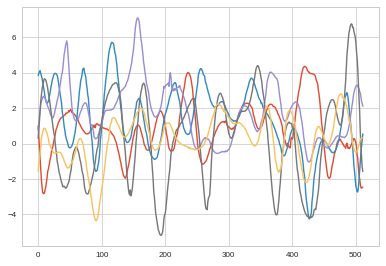

In [279]:
plt.plot(standard_diff_len_matrix_n128.T)
plt.show()

In [280]:
#standard_diff_len
standard_diff_len_n1 = standard_diff_len_matrix_n1.flatten()
standard_diff_len_n8 = standard_diff_len_matrix_n8.flatten()
standard_diff_len_n128 = standard_diff_len_matrix_n128.flatten()


In [281]:
#standard_diff_amp
standard_diff_amp_n1 = standard_diff_amp_matrix_n1.flatten()
standard_diff_amp_n8 = standard_diff_amp_matrix_n8.flatten()
standard_diff_amp_n128 = standard_diff_amp_matrix_n128.flatten()


In [282]:
#diff_len
diff_len_n1 = diff_len_matrix_n1.flatten()
diff_len_n8 = diff_len_matrix_n8.flatten()
diff_len_n128 = diff_len_matrix_n128.flatten()


In [283]:
#diff_amp
diff_amp_n1 = diff_amp_matrix_n1.flatten()
diff_amp_n8 = diff_amp_matrix_n8.flatten()
diff_amp_n128 = diff_amp_matrix_n128.flatten()


In [ ]:
from sklearn.neighbors import KernelDensity


In [300]:

matrix_list = [diff_len_matrix_n1,
               diff_len_matrix_n8,
               diff_len_matrix_n128,
               diff_amp_matrix_n1,
               diff_amp_matrix_n8,
               diff_amp_matrix_n128,
               standard_diff_len_matrix_n1, 
               standard_diff_len_matrix_n8,
               standard_diff_len_matrix_n128,
               standard_diff_amp_matrix_n1,
               standard_diff_amp_matrix_n8,
               standard_diff_amp_matrix_n128
               ]


In [303]:
opt_bandwidths = []

for matrix in matrix_list:
    prev_score = -1e12
    bw = 1.0
    interval = 1.0
    
    

    while True:
        cv_score = 0
        for i in range(5):
            train = np.delete(matrix,i,axis=0).reshape(-1,1)
            test = matrix[i].reshape(-1,1)
            kde = KernelDensity(kernel="gaussian", bandwidth=bw).fit(train)
            log_dens = kde.score_samples(test[::8]).sum()
            cv_score+=log_dens
        #
        if cv_score<prev_score: # turn around if it gets worse
            interval/=-10.0
        prev_score=cv_score
        if abs(interval)<0.0001: break
        bw += interval
        if bw<0:
            bw-=interval
            interval/=10.0
            bw += interval
    print(cv_score,bw,interval)
    opt_bandwidths.append(bw)
    
    


-0.19194105390371252 0.10749999999999935 1e-05
305.46963382671674 0.032599999999999345 1e-05
633.0450010949598 0.016599999999999386 1e-05
192.53271599555404 0.06259999999999935 1e-05
500.52540634304194 0.02389999999999939 1e-05
745.9474381232158 0.00959999999999937 -1e-05
-739.1289692458147 1.1942 -1e-05
-696.468528105329 0.7745999999999992 -1e-05
-678.082761760678 0.7378999999999993 -1e-05
-664.4200973650313 0.9232999999999992 -1e-05
-652.0240738291434 0.7059999999999993 -1e-05
-719.2098600774822 0.9365999999999992 -1e-05


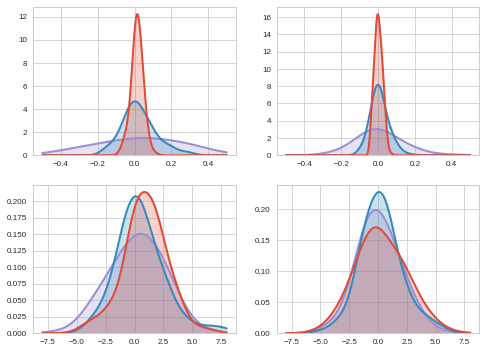

In [333]:
#create a 2x2 plot

from scipy.stats import norm

x=np.linspace(-0.5,0.5,1000)
fig, axs = plt.subplots(2,2, figsize=(8,6))

colors = ['C2','C1','C0']

i = 0


row = axs[0]
for ax in row:
    for c in range(3):
        kde = KernelDensity(kernel="gaussian", bandwidth=opt_bandwidths[i]).fit(matrix_list[i].reshape(-1,1))#,bw_method=0.1)
        density = np.exp(kde.score_samples(x.reshape(-1,1)))
        ax.plot(x,density,colors[c],lw=2)
        ax.fill_between(x,density,color=colors[c],alpha=0.25)
        i+=1
    ax.set_ylim(bottom=0)

x=np.linspace(-8,8,1000)


row = axs[1]
for ax in row:
    for c in range(3):
        kde = KernelDensity(kernel="gaussian", bandwidth=opt_bandwidths[i]).fit(matrix_list[i].reshape(-1,1))#,bw_method=0.1)
        density = np.exp(kde.score_samples(x.reshape(-1,1)))
        ax.plot(x,density,colors[c],lw=2)
        ax.fill_between(x,density,color=colors[c],alpha=0.25)
        
        i+=1
    #ax.plot(x,norm.pdf(x),'black')

    ax.set_ylim(bottom=0)

# ax0 = axs[0, 0].plot(x,kernel_diff_len_n8(x),'b-')
# ax0 = axs[0, 0].plot(x,kernel_diff_len_n128(x),'black')
# #axs[0,0].set_xlabel('Time',size=20)
# axs[0,0].set_ylabel('PDF diff len',size=20)
# axs[0,0].text(-0.08,1,'A', size=30, transform=axs[0, 0].transAxes)
# axs[0,0].tick_params(axis='both', which='major', labelsize=20)


# ax01 = axs[0, 1].plot(x,kernel_diff_amp_n1(x),'r-')
# ax01 = axs[0, 1].plot(x,kernel_diff_amp_n8(x),'b-')
# #ax01 = axs[0, 1].plot(x,kernel_diff_amp_n128(x),'black')
# ax01 = axs[0, 1].plot(x,np.exp(kernel_diff_amp_n128.score_samples(x.reshape(-1,1))),'black')

# #axs[0,1].set_xlabel('Time',size=20)
# axs[0,1].set_ylabel('Pdf diff amp',size=20)
# axs[0,1].text(-0.08,1,'B', size=30, transform=axs[0, 1].transAxes)
# axs[0,1].tick_params(axis='both', which='major', labelsize=20)


# x=np.linspace(-8,8,1000)
# #ax10 = axs[1, 0].plot(x,kernel_standard_diff_len_n1(x),'r-')
# ax10 = axs[1, 0].plot(x,np.exp(kernel_standard_diff_len_n1.score_samples(x.reshape(-1,1))),'r-')

# ax10 = axs[1, 0].plot(x,kernel_standard_diff_len_n8(x),'b-')
# ax10 = axs[1, 0].plot(x,kernel_standard_diff_len_n128(x),'black')

# #ax10 = axs[1, 0].plot(x,norm.pdf(x),'black')

# #axs[1,0].set_xlabel('x',size=20)
# axs[1,0].set_ylabel('PDF standard diff len',size=20)
# axs[1,0].text(-0.08,1,'C', size=30, transform=axs[1, 0].transAxes)
# axs[1,0].tick_params(axis='both', which='major', labelsize=20)

# ax11 = axs[1, 1].plot(x,kernel_standard_diff_amp_n1(x),'r-')
# ax11 = axs[1, 1].plot(x,kernel_standard_diff_amp_n8(x),'b-')
# #ax11 = axs[1, 1].plot(x,kernel_standard_diff_amp_n128(x),'black')
# ax11 = axs[1, 1].plot(x,np.exp(kernel_standard_diff_amp_n128.score_samples(x.reshape(-1,1))),'black')

# #ax11 = axs[1, 1].plot(x,norm.pdf(x),'black')



# #axs[1,1].set_xlabel('x',size=20)
# axs[1,1].set_ylabel('PDF standard diff amp',size=20)
# axs[1,1].text(-0.08,1,'D', size=30, transform=axs[1, 1].transAxes)
# axs[1,1].tick_params(axis='both', which='major', labelsize=20)

# fig.tight_layout()

# #plt.savefig("Synthetic-inference-unc-quantif-vi.png",dpi=600)




In [ ]:
x=np.linspace(-4,4,1000)
kde = KernelDensity(kernel="gaussian", bandwidth=opt_bandwidths[6]).fit(matrix_list[6].reshape(-1,1))
density = np.exp(kde.score_samples(x.reshape(-1,1)))
plt.hist(standard_diff_len_matrix_n1.reshape(-1,),color='blue',density=True,label='Std. diff. len n1 hist.')
plt.plot(x,density,color='red',lw=2,label='Std. diff. len. n1 pdf')
plt.plot(x, norm.pdf(x, 0, 1),'--',markersize=1,lw=2,color='k',label='Std. Normal data pdf')
plt.xlabel('Standardised difference between true and predicted lengthscale')
plt.text(-4.5,0.45,'A', size=20)
plt.legend()
plt.savefig("Hist_len_n1_all.pdf",dpi=600)
plt.show()
